# Movie Reviews Recommender Systems: Web-Scraping, Predictions, User-Item Bias, RMSE, Content-Based & Collaborative Filtering
The goal of this project is to predict movie ratings with top critic ratings information web scraped from Rotten Tomatoes. The predictions will first look at only raw averages across all training dataset ratings. Then, predictions will be modified to account for bias by normalizing across users and across items. Finally, content-based and collaborative filtering algorithms will be created and evaluated.

These goals are separated into two parts, as detailed below.

* **Part 1**: Rotten Tomatoes Web-Scraping, User-Item Matrix, Raw Mean, Bias, RMSE
* **Part 2**: Content-Based Filtering, Collaborative Filtering


## Set-Up

The following packages will be used for math, web scraping, machine learning, visualization, and other basic functions.

In [19]:
#Basic
import pandas as pd
import numpy as np
import re

#Math
import math
from fractions import Fraction

#Webscraping
import urllib.request
from bs4 import BeautifulSoup
import json
import requests

#Machine Learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
import random

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

#Content-based filtering
from rake_nltk import Rake
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

## Part 1 Procedure
### Web-Scraping, User-Item Matrix, Raw Mean, Bias, RMSE

* Obtain and Clean Dataset: The dataset used will be web scraped from Rotten Tomatoes top critic reviews.

* Create User-Item Matrix: Movies that have been reviewed by at least half of the selected critics will be included in the predictions.

* Train Test Split: Split the remaining reviews between a train and test dataset, using a test size of 20% and stratifying by movie.

* Make Predictions: Make predictions for train and test reviews based on raw average and user-item bias.

* Evaluate Results: Determine the Root Mean Square Error of predictions to evaluate the accuracy of the model.

## Obtain and Clean Dataset
Rotten Tomatoes has a paginated list of movie reviews for every critic on their website. The following code chunk creates and executes a function `scrape_rotten_tomatoes` that accepts the following variables:
* `reviewer list`: a list of critics to include in the model
* `pages`: the number of pages of reviews to scrape 

For this dataset, nine top critics have been selected and the first five pages of their reviews have been scraped from Rotten Tomatoes. 

![reviews_table](https://raw.githubusercontent.com/mkivenson/Recommender-Systems/master/Global%20Baseline%20Predictors%20and%20RSME/Review_Table.png)

The function `scrape_rotten_tomatoes` includes the following steps:
* Create empty pandas dataframe to store scraped records in
* Use BeautifulSoup to web scrape json string of movie reviews for each critic and each page
* Extract relevant items from json string into a pandas dataframe
* Remove reviews with no ratings (some critics only evaluate a movie as rotten or fresh, with no numeric rating)
* Convert any letter ratings into a fractional rating (ex. A+ = 100/100)
* Convert fraction ratings to floats (most critics score movies out of 4, 5, or 10)
* Return the resulting dataframe without duplicate records (if over-pagination occurs)

In [2]:
def scrape_rotten_tomatoes(reviewer_list, pages):
    # Create empty pandas dataframe
    reviews = pd.DataFrame(columns = ['author','movie','rating','tomatometer','date','review'])
    
    # Use BeautifulSoup to web scrape json string of movie reviews for each reviewer page
    for x in reviewer_list:
        page_range = range(1,pages+1) # Pagination
        for i in page_range:
            URL = "https://www.rottentomatoes.com/critic/" + x + "/movies?page=" + str(i) 
            page = urllib.request.urlopen(URL)
            soup = BeautifulSoup(page)
            json_tag = soup.select('head script[type="application/ld+json"]')[0]
            json_string = json_tag.string
            json_string = json.loads(str(json_string))

            # Pull relevant items from json string into a pandas dataframe
            for thing in json_string['@graph'][1]['itemListElement']:
                reviews = reviews.append({
                    'author': thing['item']['author']['name'],
                    'movie': thing['item']['itemReviewed']['name'],
                    'rating': thing['item']['reviewRating']['ratingValue'],
                    'tomatometer': thing['item']['reviewRating']['tomatometer'],
                    'date': thing['item']['datePublished'],
                    'review': thing['item']['reviewBody']
                }, ignore_index = True)
                
    # Remove reviews with empty ratings
    reviews = reviews[pd.notnull(reviews.rating)]
    
    # Convert any letter grades to fraction grades (rare scenario)
    def letter_to_frac(x):
        x = x.replace(r'A+',"100/100")
        x = x.replace(r'A-',"90/100")
        x = x.replace(r'A',"95/100")
        x = x.replace(r'B+',"85/100")
        x = x.replace(r'B-',"75/100")
        x = x.replace(r'B',"80/100")
        x = x.replace(r'C+',"65/100")
        x = x.replace(r'C-',"55/100")
        x = x.replace(r'C',"60/100")
        x = x.replace(r'D+',"45/100")
        x = x.replace(r'D-',"35/100")
        x = x.replace(r'D',"40/100")
        x = x.replace(r'F',"20/100")
        return x
    reviews.loc[:, 'rating'] = letter_to_frac(reviews.rating)
    
    # Convert fraction grades to floats
    reviews["rating"] = reviews["rating"].apply(lambda x: float(float(x.split( '/' )[0]) / float(x.split( '/' )[1])))
    
    # Return the resulting clean dataframe without duplicates (caused if there is excessive pagination)
    return reviews.drop_duplicates()

# Define a list of reviewers using format "firstname-lastname"
reviewer_list = ["christy-lemire",
           "pete-hammond",
           "matthew-lickona",
           "rafer-guzman",
           "peter-howell",
           "richard-roeper",
           "ty-burr",
           "james-berardinelli",
           "katie-walsh"]

# Provide the amount of pages to iterate through
pages = 5

# Run the web-scraping and clean-up function and assign to the dataframe 'reviews'
reviews = scrape_rotten_tomatoes(reviewer_list, pages)
reviews.head()

,author,movie,rating,tomatometer,date,review
0,Christy Lemire,The Secret Life of Pets 2,0.500,rotten,"Jun 6, 2019","Your kids will be sufficiently entertained, bu..."
1,Christy Lemire,Rocketman,0.625,fresh,"May 28, 2019",Egerton gives a performance with such thrills ...
2,Christy Lemire,Running with Beto,0.750,fresh,"May 28, 2019","Running With Beto is an intimate, thorough loo..."
3,Christy Lemire,The Sun Is Also a Star,0.625,fresh,"May 16, 2019",The leads are so lovely and the city is so shi...
4,Christy Lemire,The Hustle,0.500,rotten,"May 10, 2019","It's not terrible. It's not anything, really, ..."


## Create User-Item Matrix
### Filter Results
To create a more condensed ratings model, only include movies that at least half of the selected critics have reviewed.

In [3]:
#Filter reviews to only show movies that at least half of reviewers have watched
movie_counts = reviews.groupby(by='movie').size()
movie_counts = pd.DataFrame(movie_counts).reset_index()
movie_counts.columns = ["movie","count_reviews"]
movie_list = list(movie_counts[movie_counts.count_reviews >= math.ceil(len(reviewer_list)/2)].movie)
print("There are " + str(len(movie_list)) + " movies that at least half of reviewers have watched.")

There are 128 movies that at least half of reviewers have watched.


### Matrix Creation
The following code chunk creates the user-item matrix for critic-movie ratings. Movies that have not been reviewed by a certain critic have values of "NaN" in the matrix.

In [4]:
#Take filtered reviews and transform into a user-item matrix
reviews_summary = reviews[reviews.movie.isin(movie_list)][["author","movie","rating"]]

reviews_matrix = reviews_summary.pivot_table(index = "movie", columns = "author", values = "rating")
reviews_matrix

author,Christy Lemire,James Berardinelli,Katie Walsh,Matthew Lickona,Pete Hammond,Peter Howell,Rafer Guzman,Richard Roeper,Ty Burr
movie,,,,,,,,,
A Private War,NaN,NaN,0.875,0.2,0.8,NaN,0.750,0.750,0.750
A Quiet Place,NaN,0.875,NaN,NaN,1.0,0.750,NaN,0.750,0.750
A Simple Favor,NaN,0.625,0.750,0.2,0.5,NaN,NaN,0.875,NaN
A Star Is Born,NaN,0.750,1.000,0.2,1.0,1.000,0.750,1.000,0.875
Aladdin,NaN,0.500,0.750,0.2,NaN,NaN,0.375,0.750,0.625
Alita: Battle Angel,NaN,0.625,0.500,NaN,0.6,0.500,0.625,0.375,NaN
American Made,NaN,NaN,NaN,0.4,0.9,0.750,0.750,NaN,0.750
Ant-Man and the Wasp,0.750,0.500,0.750,0.2,0.7,0.750,0.625,0.750,0.875
Aquaman,NaN,0.625,0.750,0.2,0.6,0.375,0.750,0.750,NaN


### Visualize Reviews
To preview potential bias in the recommender system, a rating overview by critic can be created. We see from the box plots below that Matthew Lickona is a particularly harsh critic. If a different list of critics is passed into the `scrape_rotten_tomatoes` function, the box plot will show different results.

Text(0.5, 1.0, 'Rating Overview by Reviewer')

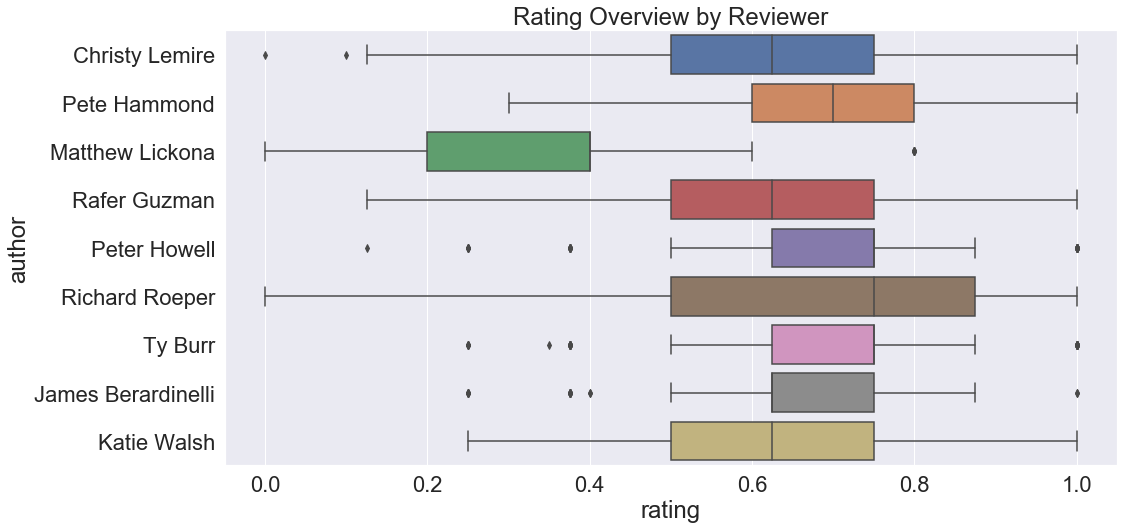

In [5]:
plt.figure(figsize=(16, 8))
sns.set_style("darkgrid")
sns.set(font_scale = 2)
sns.boxplot(x = "rating", y = "author", data = reviews).set_title('Rating Overview by Reviewer')

## Train Test Split
To begin creating movie rating predictions for each critic, the reviews data is split between a test set and a train set. The test size will be 20% of the total reviews, and the split between train and test sets by stratifying by movie.

In [6]:
X = reviews_summary[["author","movie","rating"]]
y = reviews_summary["rating"]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify = X["movie"], 
                                                    random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(632, 3) (632,)
(158, 3) (158,)


## Make Predictions and Evaluate Results
### Raw Average Rating
The next step is to calculate the raw average (mean) rating for every critic-movie combination.

In [7]:
train_mean = round(y_train.mean(),2)
print("The mean rating for all reviewers/all movies in the train set is " + str(train_mean) + ".")

The mean rating for all reviewers/all movies in the train set is 0.64.


### Root Mean Square Error for Raw Average
The RMSE for using raw average as the predictor for both the training data and the test data is calculated below.

In [8]:
MSE_train = 0
for x in y_train:
    MSE_train = MSE_train + ((train_mean - x) ** 2)
RMSE_train = round(math.sqrt(MSE_train / len(y_train)),5)
print("The RMSE using the raw average as the predicted value for train data is " + str(RMSE_train) + ".")

MSE_test = 0
for x in y_test:
    MSE_test = MSE_test + ((train_mean - x) ** 2)
RMSE_test = round(math.sqrt(MSE_test / len(y_test)),5)
print("The RMSE using the raw average as the predicted value for test data is " + str(RMSE_test) + ".")

The RMSE using the raw average as the predicted value for train data is 0.22026.
The RMSE using the raw average as the predicted value for test data is 0.20552.


### Bias Calculations
To make the predictions more accurate, we take into account movie and critic bias. We saw from the visualization earlier that some critics are harsher than others. Similarly, some movies are of better quality than others. By taking critic harshness and movie quality into account, we can make these biases reflected in the predictions.

In [9]:
author_bias = X_train.groupby(by="author").agg("mean").reset_index()
author_bias = author_bias.assign(author_bias = lambda author_bias: author_bias.rating - train_mean)
movie_bias = X_train.groupby(by="movie").agg("mean").reset_index()
movie_bias = movie_bias.assign(movie_bias = lambda movie_bias: movie_bias.rating - train_mean)

In [10]:
#Add author_bias and movie_bias to the train set
X_train_bias = pd.merge(X_train, author_bias[["author","author_bias"]], how = 'left', on = "author")
X_train_bias = pd.merge(X_train_bias, movie_bias[["movie","movie_bias"]], how = 'left', on = "movie")
X_train_bias = X_train_bias[["author","movie","rating","author_bias","movie_bias"]]

#Add baseline predictor to the train set
X_train_bias = X_train_bias.assign(
    predictor = lambda X_train_bias: (train_mean + X_train_bias.author_bias + X_train_bias.movie_bias))
X_train_bias.predictor = X_train_bias.predictor.apply(lambda x: max(min(x,1),0))

#Add author_bias and movie_bias to the test set
X_test_bias = pd.merge(X_test, author_bias[["author","author_bias"]], how = 'left', on = "author")
X_test_bias = pd.merge(X_test_bias, movie_bias[["movie","movie_bias"]], how = 'left', on = "movie")
X_test_bias = X_test_bias[["author","movie","rating","author_bias","movie_bias"]]

#Add baseline predictor to the test set
X_test_bias = X_test_bias.assign(
    predictor = lambda X_test_bias: (train_mean + X_test_bias.author_bias + X_test_bias.movie_bias))
X_test_bias.predictor = X_test_bias.predictor.apply(lambda x: max(min(x,1),0))

### RMSE for Baseline Predictors
After taking bias into account in the baseline predictions, we see the RMSE calculations for both train and test data decrease.

In [11]:
MSE_train_bias = 0
for i in range(len(X_train_bias.predictor)):
    MSE_train_bias = MSE_train_bias + ((X_train_bias.rating[i] - X_train_bias.predictor[i]) ** 2)
RMSE_train_bias = round(math.sqrt(MSE_train_bias / len(X_train_bias)),5)
print("The RMSE using bias in the predicted value calculations for train data is " + str(RMSE_train_bias) + ".")

The RMSE using bias in the predicted value calculations for train data is 0.12609.


In [12]:
MSE_test_bias = 0
for i in range(len(X_test_bias.predictor)):
    MSE_test_bias = MSE_test_bias + ((X_test_bias.rating[i] - X_test_bias.predictor[i]) ** 2)
RMSE_test_bias = round(math.sqrt(MSE_test_bias / len(X_test_bias)),5)
print("The RMSE using bias in the predicted value calculations for test data is " + str(RMSE_test_bias) + ".")

The RMSE using bias in the predicted value calculations for test data is 0.1469.


## Summary
The prediction accuracy results are summarized below. It is evident that taking bias into account will improve prediction accuracy.

In [13]:
print("The RMSE for the raw mean predictor for the train set is " + str(RMSE_train))
print("The RMSE for the raw mean predictor for the test set is " + str(RMSE_test))
print("The RMSE for the raw mean with bias predictor for the train set is " + str(RMSE_train_bias))
print("The RMSE for the raw mean with bias predictor for the test set is " + str(RMSE_test_bias))

The RMSE for the raw mean predictor for the train set is 0.22026
The RMSE for the raw mean predictor for the test set is 0.20552
The RMSE for the raw mean with bias predictor for the train set is 0.12609
The RMSE for the raw mean with bias predictor for the test set is 0.1469


### Actual Ratings vs Predictions
It is also helpful to visualize a comparison of the predicted and actual ratings for the train and test sets. From the plots below, we see that the predicted and actual reviews are strongly correlated.

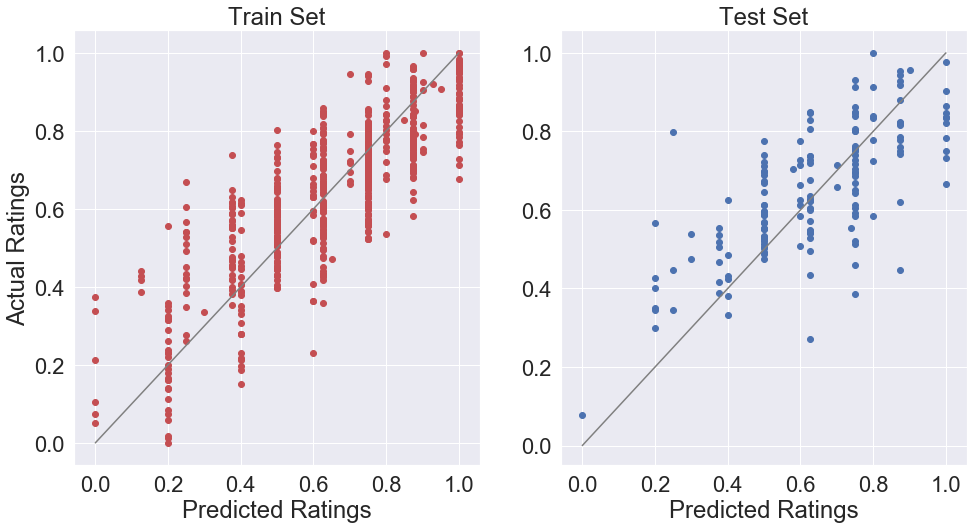

In [14]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(X_train_bias["rating"], X_train_bias["predictor"], color='r')
x = np.arange(0,1.1,.1)
plt.plot(x, x + 0, linestyle='solid', color="gray")
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.title('Train Set')


plt.subplot(1, 2, 2)
plt.scatter(X_test_bias["rating"], X_test_bias["predictor"], color='b')
plt.plot(x, x + 0, linestyle='solid', color="gray")
plt.xlabel('Predicted Ratings')
plt.title('Test Set')
plt.show()

### Residuals
Looking at the residuals created by the difference between actual and predicted values is also an insightful visualization. For both the train and test sets, the residuals are symmetrically distributed and are mostly clustered around 0. 

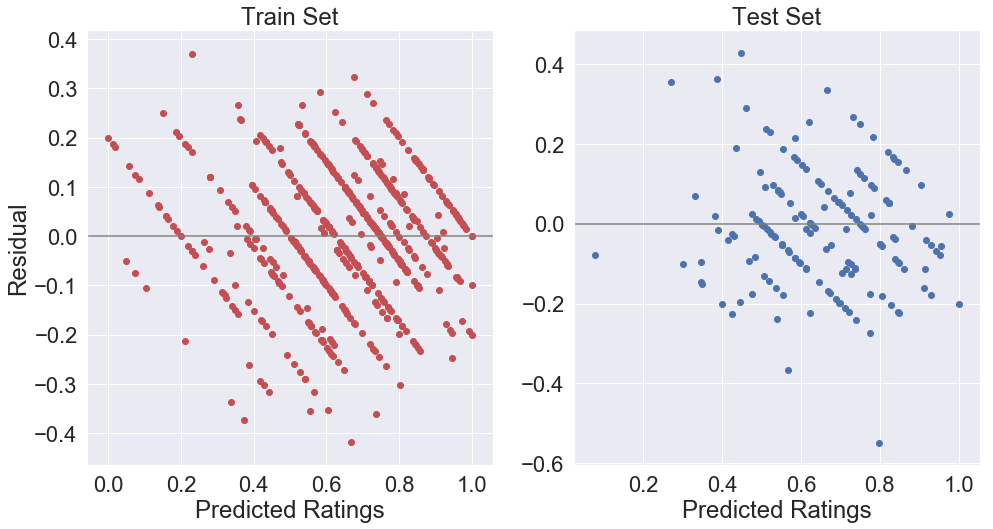

In [15]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(X_train_bias["predictor"],X_train_bias["rating"] - X_train_bias["predictor"], color='r')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residual')
plt.axhline(y=0, color='gray')
plt.title('Train Set')

plt.subplot(1, 2, 2)
plt.scatter(X_test_bias["predictor"],X_test_bias["rating"] - X_test_bias["predictor"], color='b')
plt.xlabel('Predicted Ratings')
plt.title('Test Set')
plt.axhline(y=0, color='gray')
plt.show()

## Part 2 Procedure

Part 2 of this project will use content-based filtering and item-item collaborative filting to create movie recommendations based on user input. An overview of the steps that will be taken is outline below

**Content Based Filtering**
* Create Movie Profiles
* Pre-Process Data
* Apply Count Vectorizer 
* Use and Evaluate Euclidian Distance Similarity Measure
* Use and Evaluate Cosine Similarity Measure
* Visualize Movie Recommendations

**Item-Item Collaborative Based Filtering**
* Visualize Distribution
* Normalize for User Bias
* Apply and Evaluate Cosine Similarity
* Normalize for Item Bias
* Apply and Evaluate Cosine Similarity
* Visualize Results

## Content-Based Filtering
### Create Movie Profiles

The first step to a content-based filtering approach is to create movie profiles for each movie in our reviews dataset. To do this, the OMDB API is used and the following fields are extracted from the json response into a pandas dataframe:
* title
* rating
* genre
* director
* writer
* actors
* plot

A try-except approach is used in the for loop because the OMDB API has issues returning information for some movies, such as Ocean's 8 (since it stores the movie name as Ocean's Eight in its database). 

In [16]:
api_key = "1ac8ac3e"
movie_profile = pd.DataFrame(columns = ["title","rated","genre","director","writer","actors","plot"])
for movie in reviews["movie"].unique():
    URL = "http://www.omdbapi.com/" \
    + "?apikey=" + api_key \
    + "&t=" + movie
    response = requests.get(URL)
    try: 
        movie_profile = movie_profile.append({
            'title': response.json()['Title'],
            'rated': response.json()['Rated'],
            'genre': response.json()['Genre'],
            'director': response.json()['Director'],
            'writer': response.json()['Writer'],
            'actors': response.json()['Actors'],
            'plot': response.json()['Plot'],
    }, ignore_index = True)
    except:
        continue
movie_profile.head()

,title,rated,genre,director,writer,actors,plot
0,The Secret Life of Pets 2,PG,"Animation, Adventure, Comedy, Family","Chris Renaud, Jonathan del Val(co-director)",Brian Lynch,"Patton Oswalt, Eric Stonestreet, Kevin Hart, J...",Continuing the story of Max and his pet friend...
1,RocketMan,PG,"Comedy, Family, Sci-Fi",Stuart Gillard,"Oren Aviv (story), Craig Mazin (story), Greg E...","Harland Williams, Jessica Lundy, William Sadle...",Fred Z. Randall is a geeky spacecraft designer...
2,Running with Beto,TV-MA,Documentary,David Modigliani,N/A,"Beto O'Rourke, Amy O'Rourke, Cynthia Cano, Jod...",A behind-the-scenes documentary following Beto...
3,The Sun Is Also a Star,PG-13,"Drama, Romance",Ry Russo-Young,"Tracy Oliver (screenplay), Nicola Yoon (novel)","Charles Melton, Yara Shahidi, Keong Sim, Gbeng...",A teenager finds love at a difficult time in h...
4,The Hustle,PG-13,Comedy,Chris Addison,"Stanley Shapiro (screenplay by), Paul Henning ...","Timothy Simons, Rebel Wilson, Douggie McMeekin...",Anne Hathaway and Rebel Wilson star as female ...


### Preprocessing
Once movie profiles for each film are created, the next step is to preprocess the profile information for each movie in order to apply text analysis techniques. To do this, Rake will be used to extract keywords from the movie plot. Then, regular expressions will be used to clean up director, writer and actor names. Each name will have lowercase, have spacing removed between first and last name, and then be added to a single column. Finally, punctuation and capital letters will be removed from the genre and rating code. All of these words will then be combined into a single string.

In [17]:
movie_words = movie_profile.copy()
#extract key words from the plot description
movie_words['key_words'] = ""
movie_words['people'] = ""
for index, row in movie_words.iterrows():
    plot = row['plot']
    r = Rake()
    r.extract_keywords_from_text(plot)
    key_words_dict_scores = r.get_word_degrees()
    row['key_words'] = ' '.join(list(key_words_dict_scores.keys()))

#combine director, writer, actor names and remove caps
for index, row in movie_words.iterrows():
    director = re.sub(r'\(.+\)|\s', '', row["director"])
    director = re.sub(r',', ' ', director).lower()
    writer = re.sub(r'\(.+\)|\s', '', row["writer"])
    writer = re.sub(r',', ' ', writer).lower()
    actors = re.sub(r'\(.+\)|\s', '', row["actors"])
    actors = re.sub(r',', ' ', actors).lower()
    row["people"] = "{} {} {}".format(director, writer, actors)                                 

#make genre lowercase, remove punctuation
for index, row in movie_words.iterrows():
    row['genre'] = re.sub(r'\-','',row['genre'])
    row['genre'] = re.sub(r',',' ',row['genre']).lower()

#make rating lowercase, remove punctuation
for index, row in movie_words.iterrows():
    row['rated'] = re.sub(r'\-','',row['rated']).lower()
    
movie_words["words"] =  "rated" + movie_words["rated"] + " " +\
                        movie_words["genre"] + " " +\
                        movie_words["people"] + " " +\
                        movie_words["key_words"]
movie_words[["title","words"]].head()

,title,words
0,The Secret Life of Pets 2,ratedpg animation adventure comedy family c...
1,RocketMan,ratedpg comedy family scifi stuartgillard or...
2,Running with Beto,ratedtvma documentary davidmodigliani n/a beto...
3,The Sun Is Also a Star,ratedpg13 drama romance ryrusso-young tracyol...
4,The Hustle,ratedpg13 comedy chrisaddison stanleyshapiro t...


### Count Vectorizer

To recommend movies, a Count Vectorizer algorithm will be used. The advantage of count vectorization over term frequency–inverse document frequency (td-idf) is that import fields such as movie ratings (PG, PG-13, R) that appear often will be considered equally despite being more frequent.

In [20]:
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

movie_matrix = count_vec.fit_transform(movie_words["words"])
movie_matrix

,The Secret Life of Pets 2,RocketMan,Running with Beto,The Sun Is Also a Star,The Hustle,Wine Country,El Chicano,Hellboy,Dumbo,Triple Frontier,...,Madame,Body at Brighton Rock,Paddleton,Donnybrook,Tyrel,Anna and the Apocalypse,The Wind,Nekrotronic,Hot Summer Nights,Breaking In
The Secret Life of Pets 2,0.000000,6.480741,7.141428,6.324555,6.782330,6.708204,6.782330,6.928203,6.928203,7.000000,...,7.280110,6.782330,7.000000,6.928203,7.000000,8.124038,6.855655,7.280110,7.745967,6.324555
RocketMan,6.480741,0.000000,7.141428,6.164414,6.633250,6.557439,6.782330,6.633250,6.928203,7.000000,...,7.141428,6.633250,6.855655,6.633250,6.855655,8.124038,6.708204,7.141428,7.615773,6.164414
Running with Beto,7.141428,7.141428,0.000000,6.708204,7.141428,7.071068,7.141428,7.141428,7.416198,7.348469,...,7.615773,7.000000,7.211103,7.141428,7.348469,8.544004,7.211103,7.745967,8.062258,6.708204
The Sun Is Also a Star,6.324555,6.164414,6.708204,0.000000,6.164414,6.244998,6.164414,6.164414,6.164414,6.403124,...,6.557439,6.164414,6.403124,6.164414,6.403124,7.874008,5.744563,7.000000,6.782330,5.291503
The Hustle,6.782330,6.633250,7.141428,6.164414,0.000000,6.557439,6.782330,6.633250,7.071068,7.000000,...,7.000000,6.633250,6.855655,6.633250,6.855655,8.124038,6.855655,7.280110,7.615773,6.164414
Wine Country,6.708204,6.557439,7.071068,6.244998,6.557439,0.000000,6.557439,6.708204,7.000000,6.782330,...,7.071068,6.403124,6.782330,6.557439,6.480741,7.937254,6.782330,7.211103,7.416198,6.244998
El Chicano,6.782330,6.782330,7.141428,6.164414,6.782330,6.557439,0.000000,6.782330,6.928203,6.708204,...,7.141428,6.480741,6.855655,6.480741,6.855655,8.124038,6.557439,7.416198,7.483315,6.164414
Hellboy,6.928203,6.633250,7.141428,6.164414,6.633250,6.708204,6.782330,0.000000,7.071068,6.708204,...,7.280110,6.633250,7.000000,6.782330,7.000000,8.000000,6.855655,7.141428,7.745967,6.000000
Dumbo,6.928203,6.928203,7.416198,6.164414,7.071068,7.000000,6.928203,7.071068,0.000000,7.141428,...,7.416198,6.782330,7.141428,6.928203,7.141428,8.366600,6.708204,7.681146,7.874008,6.324555
Triple Frontier,7.000000,7.000000,7.348469,6.403124,7.000000,6.782330,6.708204,6.708204,7.141428,0.000000,...,7.348469,6.403124,7.071068,6.708204,7.071068,8.306624,6.928203,7.615773,7.549834,5.916080


### Euclidean Distance

For a basic comparison on the similarity of movies, the euclidean distance can be measured. 

In [ ]:
#euclidean distance
euclidean_matrix = euclidean_distances(movie_matrix, movie_matrix)
euclidean_matrix = pd.DataFrame(euclidean_matrix)
euclidean_matrix.columns = list(movie_words["title"])
euclidean_matrix.index = list(movie_words["title"])
euclidean_matrix

### Evaluate Euclidean Distance
We can now create a function to recommend movies based on a movie that the user has enjoyed. The inputs for this function `content_recommender` will be the movie and matrix to be used, as well as whether results should be sorted in ascending order or not. This is because for Euclidean Distance, movies with the lowest scores  are the most similar (so results must be sorted in ascending order). On the other hand, for Cosine Similarity, movies with the greatest scores are most similar (so results must be sorted in descending order). 

In [ ]:
def content_recommender(movie, matrix, ascend):
    matrix = matrix.sort_values(movie,ascending=ascend)
    print("Recommended Movie | Value")
    for i in range(1,11): 
        print (matrix[movie].index.values[i] + " | " + str(round(matrix[movie][i],3)))
    print("\n")

Using the `content_recommender` function, we can test out the recommendations for a few movies. For this exercise, we used the following movies from different genres:
* Avengers: Endgame (superhero/action movie)
* The Secret Life of Pets 2 (animated children's movie)
* Us (Thriller/Horror movie)

In [ ]:
#superhero movie
content_recommender("Avengers: Endgame", euclidean_matrix, True)

In [ ]:
#children's movie
content_recommender("The Secret Life of Pets 2", euclidean_matrix, True)

In [ ]:
#horror/thriller movie
content_recommender("Us", euclidean_matrix, True)

### Cosine Similarity

In addition to applying euclidean distance to the text describing each movie, it will also help to use cosine similarity in this content-based recommender system. First, the cosine_matrix of similarity measures between each movie is created.

In [21]:
#cosine similarity
cosine_matrix = cosine_similarity(movie_matrix, movie_matrix)
cosine_matrix = pd.DataFrame(cosine_matrix)
cosine_matrix.columns = list(movie_words["title"])
cosine_matrix.index = list(movie_words["title"])
cosine_matrix

,The Secret Life of Pets 2,RocketMan,Running with Beto,The Sun Is Also a Star,The Hustle,Wine Country,El Chicano,Hellboy,Dumbo,Triple Frontier,...,Madame,Body at Brighton Rock,Paddleton,Donnybrook,Tyrel,Anna and the Apocalypse,The Wind,Nekrotronic,Hot Summer Nights,Breaking In
The Secret Life of Pets 2,1.000000,0.125109,0.037796,0.048507,0.041703,0.042640,0.041703,0.000000,0.076980,0.039223,...,0.036515,0.000000,0.039223,0.000000,0.039223,0.059628,0.040825,0.070711,0.032880,0.048507
RocketMan,0.125109,1.000000,0.000000,0.050572,0.043478,0.044455,0.000000,0.043478,0.040129,0.000000,...,0.038069,0.000000,0.040893,0.043478,0.040893,0.031083,0.042563,0.073721,0.034280,0.050572
Running with Beto,0.037796,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.037062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
The Sun Is Also a Star,0.048507,0.050572,0.000000,1.000000,0.050572,0.000000,0.050572,0.050572,0.140028,0.047565,...,0.088561,0.000000,0.047565,0.050572,0.047565,0.000000,0.198030,0.000000,0.159490,0.176471
The Hustle,0.041703,0.043478,0.000000,0.050572,1.000000,0.044455,0.000000,0.043478,0.000000,0.000000,...,0.076139,0.000000,0.040893,0.043478,0.040893,0.031083,0.000000,0.036860,0.034280,0.050572
Wine Country,0.042640,0.044455,0.000000,0.000000,0.044455,1.000000,0.044455,0.000000,0.000000,0.041812,...,0.038925,0.046524,0.041812,0.044455,0.125436,0.063564,0.000000,0.037689,0.070100,0.000000
El Chicano,0.041703,0.000000,0.000000,0.050572,0.000000,0.044455,1.000000,0.000000,0.040129,0.081786,...,0.038069,0.045502,0.040893,0.086957,0.040893,0.031083,0.085126,0.000000,0.068559,0.050572
Hellboy,0.000000,0.043478,0.000000,0.050572,0.043478,0.000000,0.000000,1.000000,0.000000,0.081786,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.062167,0.000000,0.073721,0.000000,0.101144
Dumbo,0.076980,0.040129,0.000000,0.140028,0.000000,0.000000,0.040129,0.000000,1.000000,0.037743,...,0.035136,0.041996,0.037743,0.040129,0.037743,0.028689,0.117851,0.000000,0.031639,0.093352
Triple Frontier,0.039223,0.000000,0.000000,0.047565,0.000000,0.041812,0.081786,0.081786,0.037743,1.000000,...,0.035806,0.128388,0.038462,0.081786,0.038462,0.029235,0.040032,0.000000,0.096724,0.190261


### Evaluate Cosine Similarity
Using the same `content_recommender` function above, a list of 10 most-recommended movies can be produced for a selected movie. Let's try this on the same movies used in the previous section and compare outcomes. 

In [23]:
content_recommender("Avengers: Endgame", cosine_matrix, False)

Recommended Movie | Value
Avengers: Infinity War | 4.796
Captain America: Civil War | 5.385
The Green Fog | 5.745
Narcissister Organ Player | 5.831
WCW/NWA Chi-Town Rumble | 5.916
Garry Winogrand: All Things are Photographable | 6.0
Through Black Spruce | 6.0
Obit | 6.083
The Valley | 6.083
The Scent of Rain | 6.164


Recommended Movie | Value
Avengers: Infinity War | 0.567
Captain America: Civil War | 0.412
Captain Marvel | 0.222
Wonder Woman | 0.2
Men in Black: International | 0.185
Aquaman | 0.182
Jurassic World: Fallen Kingdom | 0.179
Star Wars: The Last Jedi | 0.175
Justice League | 0.173
Solo: A Star Wars Story | 0.173




In [ ]:
content_recommender("The Secret Life of Pets 2", cosine_matrix, False)

In [ ]:
content_recommender("Us", cosine_matrix, False)

### Visualize Movie Recommendations
To see recommendations at a larger scale, the following heatmap of movie cosine similarites is created. The script selects 15 movies randomly from the entire movies dataframe to avoid overcrowding the chart. Each movie has a cosine similarity of 1 with inselt, and much lower similarities with other movies. A cosine similarity of 0.15 or above between movies indicates that those movies are likely to be highly recommended.

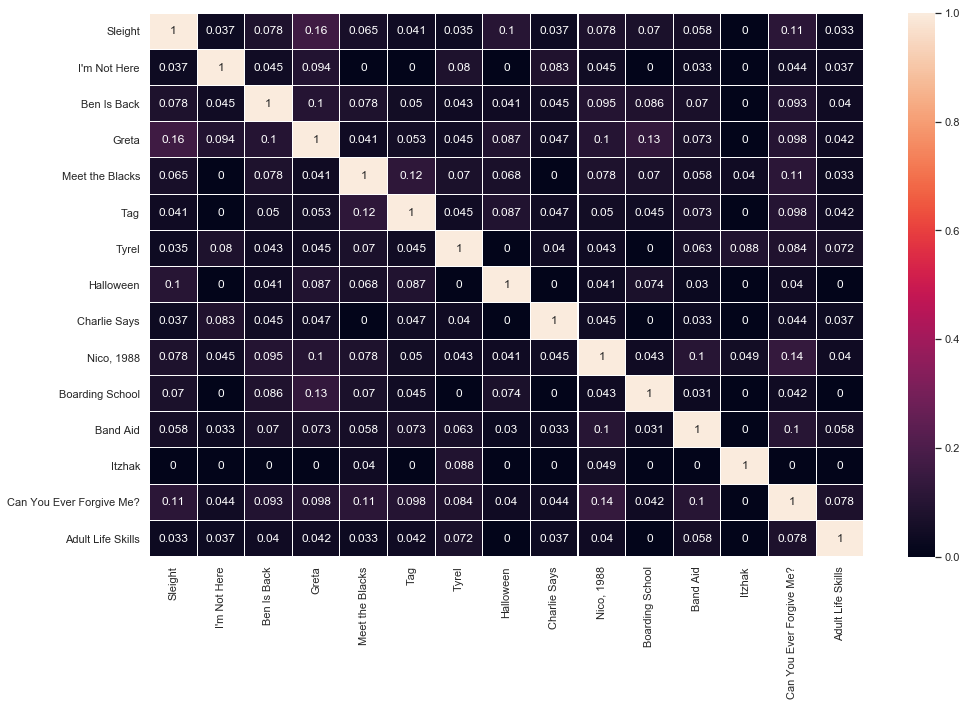

In [24]:
plt.figure(figsize=(16, 10))
sns.set_style("darkgrid")
sns.set(font_scale = 1)
x = random.sample(range(0, len(cosine_matrix) + 1), 15)
sns.heatmap(cosine_matrix.iloc[x,x], linewidths=.1, annot=True)

## Item-Item Collaborative Filtering
### Rating Distribution
We can begin by visualizing the distribution of movie reviews. This shows where most of the reviews are centered and it seems like the distribution of reviews is nearly-normal. 

In [ ]:
### Visualization
plt.figure(figsize=(16, 10))
sns.set_style("darkgrid")
sns.set(font_scale = 2)
sns.distplot(reviews["rating"]).set_xlim(0,1)

### Normalize for User Bias
The next step is to create a user-item matrix normalized for critic bias. To do this, we subtract each critic's mean rating from their individual movie ratings. 

In [64]:
reviews_matrix_transpose = reviews_matrix.transpose()
critic_means = reviews_matrix_transpose.mean(axis=1)
reviews_matrix_transpose = (reviews_matrix_transpose - critic_means[:,None]).fillna(0)
reviews_matrix_transpose

movie,A Private War,A Quiet Place,A Simple Favor,A Star Is Born,Aladdin,Alita: Battle Angel,American Made,Ant-Man and the Wasp,Aquaman,Avengers: Endgame,...,The Wife,Tolkien,Tomb Raider,Tully,Unsane,Us,Venom,Vice,Vox Lux,Widows
author,,,,,,,,,,,,,,,,,,,,,
Christy Lemire,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101226,0.000000,0.000000,...,0.101226,0.000000,0.000000,0.226226,0.000000,0.000000,-0.148774,0.000000,0.000000,0.000000
James Berardinelli,0.000000,0.215476,-0.034524,0.090476,-0.159524,-0.034524,0.000000,-0.159524,-0.034524,0.090476,...,0.090476,-0.034524,0.000000,-0.034524,0.090476,-0.034524,-0.159524,-0.034524,0.090476,0.215476
Katie Walsh,0.185882,0.000000,0.060882,0.310882,0.060882,-0.189118,0.000000,0.060882,0.060882,0.000000,...,0.000000,0.000000,0.000000,0.310882,0.000000,0.185882,-0.064118,0.060882,-0.189118,0.185882
Matthew Lickona,-0.084507,0.000000,-0.084507,-0.084507,-0.084507,0.000000,0.115493,-0.084507,-0.084507,0.115493,...,0.000000,0.315493,-0.084507,0.000000,0.315493,-0.084507,-0.284507,0.000000,0.000000,0.000000
Pete Hammond,0.092632,0.292632,-0.207368,0.292632,0.000000,-0.107368,0.192632,-0.007368,-0.107368,0.092632,...,0.292632,-0.107368,-0.107368,0.000000,-0.107368,-0.107368,-0.207368,0.092632,0.000000,-0.007368
Peter Howell,0.000000,0.081579,0.000000,0.331579,0.000000,-0.168421,0.081579,0.081579,-0.293421,0.206579,...,0.000000,-0.168421,-0.168421,-0.043421,0.000000,0.206579,-0.168421,0.081579,-0.168421,0.331579
Rafer Guzman,0.106250,0.000000,0.000000,0.106250,-0.268750,-0.018750,0.106250,-0.018750,0.106250,0.106250,...,0.000000,-0.018750,0.106250,0.231250,0.231250,0.231250,-0.518750,-0.393750,0.106250,0.000000
Richard Roeper,0.049757,0.049757,0.174757,0.299757,0.049757,-0.325243,0.000000,0.049757,0.049757,0.299757,...,0.174757,-0.200243,-0.200243,0.000000,0.049757,0.299757,-0.325243,0.049757,-0.450243,0.299757
Ty Burr,0.079321,0.079321,0.000000,0.204321,-0.045679,0.000000,0.079321,0.204321,0.000000,0.000000,...,-0.045679,-0.045679,-0.295679,0.079321,0.079321,0.029321,-0.295679,-0.295679,0.000000,0.000000


### Item-Item Cosine Similarity
Next, and item-item matrix is created with cosine similarity values. The cosine similarity values indicate how related each movie is based on critic reception, on a scale of 1 to -1. 

In [67]:
item_cosine_matrix = cosine_similarity(reviews_matrix_transpose.transpose())
item_cosine_matrix = pd.DataFrame(item_cosine_matrix)
item_cosine_matrix.columns = list(reviews_matrix.index.values)
item_cosine_matrix.index = list(reviews_matrix.index.values)
item_cosine_matrix

,A Private War,A Quiet Place,A Simple Favor,A Star Is Born,Aladdin,Alita: Battle Angel,American Made,Ant-Man and the Wasp,Aquaman,Avengers: Endgame,...,The Wife,Tolkien,Tomb Raider,Tully,Unsane,Us,Venom,Vice,Vox Lux,Widows
A Private War,1.000000,0.352239,0.102407,0.755366,-0.126078,-0.557762,0.354124,0.415522,0.239103,0.226266,...,0.328192,-0.459801,-0.218077,0.728284,-0.028936,0.564682,-0.470433,-0.314313,-0.326041,0.347124
A Quiet Place,0.352239,1.000000,-0.528946,0.633567,-0.275048,-0.418684,0.660477,-0.093176,-0.447070,0.489323,...,0.776135,-0.402691,-0.474610,-0.026604,-0.019292,-0.025260,-0.473493,0.027034,-0.081009,0.423741
A Simple Favor,0.102407,-0.528946,1.000000,0.074601,0.254642,-0.358762,-0.621740,0.290481,0.418381,0.166327,...,-0.307566,-0.305102,-0.044305,0.149836,0.009430,0.656237,0.049455,-0.037279,-0.596153,0.372770
A Star Is Born,0.755366,0.633567,0.074601,1.000000,-0.050232,-0.866144,0.551524,0.434453,-0.337427,0.697303,...,0.551592,-0.655914,-0.654164,0.389233,0.020276,0.665206,-0.620383,-0.050279,-0.640793,0.772982
Aladdin,-0.126078,-0.275048,0.254642,-0.050232,1.000000,-0.119226,-0.456350,0.327798,-0.082302,-0.269765,...,-0.029366,-0.166706,-0.123269,-0.267815,-0.728664,-0.148969,0.664206,0.756727,-0.427386,-0.045685
Alita: Battle Angel,-0.557762,-0.418684,-0.358762,-0.866144,-0.119226,1.000000,-0.311500,-0.260002,0.215915,-0.825954,...,-0.577800,0.582094,0.558692,-0.278211,-0.066478,-0.756975,0.526301,-0.194370,0.897586,-0.860821
American Made,0.354124,0.660477,-0.621740,0.551524,-0.456350,-0.311500,1.000000,0.113374,-0.448814,0.520528,...,0.522056,-0.030785,-0.478281,0.217806,0.400410,0.099125,-0.740183,-0.289914,-0.016758,0.176980
Ant-Man and the Wasp,0.415522,-0.093176,0.290481,0.434453,0.327798,-0.260002,0.113374,1.000000,-0.057395,0.037564,...,-0.060363,-0.396302,-0.579786,0.387738,-0.194799,0.378688,-0.190178,-0.219634,-0.382892,0.114405
Aquaman,0.239103,-0.447070,0.418381,-0.337427,-0.082302,0.215915,-0.448814,-0.057395,1.000000,-0.390670,...,-0.198993,0.156436,0.458306,0.356146,0.058723,0.058232,0.090764,-0.377841,0.125894,-0.417380
Avengers: Endgame,0.226266,0.489323,0.166327,0.697303,-0.269765,-0.825954,0.520528,0.037564,-0.390670,1.000000,...,0.568640,-0.411478,-0.574198,0.065181,0.417423,0.655452,-0.745848,-0.021476,-0.673434,0.801626


### Evaluate Item-Item Similarity
We can now create a another function to recommend movies based on a movie that the user has enjoyed. The inputs for this function `item_recommender` will be the movie and matrix to be used.

In [69]:
def item_recommender(movie, matrix):
    matrix = matrix.sort_values(movie,ascending=False)
    print("Recommended Movie | Value")
    for i in range(1,11): 
        print (matrix[movie].index.values[i] + " | " + str(round(matrix[movie][i],3)))
    print("\n")

Recommended Movie | Value
Avengers: Endgame | 0.842
Roma | 0.772
Disobedience | 0.768
Green Book | 0.732
Widows | 0.727
Chappaquiddick | 0.701
Gloria Bell | 0.688
Eighth Grade | 0.682
Hereditary | 0.68
Blade Runner 2049 | 0.649




Using the `item_recommender` function, top ten recommended movies are produced for the same three movies. However, results are not as good. For example, when "The Secret Life of Pets 2" is the input for the item_recommended function, one of the recommended movies is A Quiet Place (a horror movie). Upon further review, all of the recommended movies are highly rated by all critics - so for most inputs, the recommended movies are just movies of similar quality. To correct this issue, we can account for item bias rather than only user bias.

In [ ]:
item_recommender("Avengers: Infinity War", item_cosine_matrix)

In [70]:
item_recommender("The Secret Life of Pets 2", item_cosine_matrix)

Recommended Movie | Value
Avengers: Endgame | 0.716
The Favourite | 0.705
A Quiet Place | 0.7
Can You Ever Forgive Me? | 0.684
American Made | 0.668
Widows | 0.656
The Disaster Artist | 0.651
Avengers: Infinity War | 0.649
Booksmart | 0.644
Green Book | 0.626




In [ ]:
item_recommender("Us", item_cosine_matrix)

### Normalize for Item Bias

### Apply and Evaluate Cosine Similarity

### Visualize Results

## Further Evaluation